# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [8]:
#import libraries
import os
import cv2
import random # used to select random points for 3d-2d correspondences
import numpy as np 
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this

In [9]:
def read_transformations(filename = "mr2020_project_data/poses.txt"):
    arr = np.loadtxt(filename)
    return arr

In [10]:
# from pose.txt
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02], 
              [0.000000e+00, 7.070912e+02, 1.831104e+02], 
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])
D = 0.53790448812

# path declaration
LEFT_IMAGE_PATH = "mr2020_project_data/img2"
RIGHT_IMAGE_PATH = "mr2020_project_data/img3"
PC_PATH = 'point_clouds'

#### Explanation
In the following two cells, we create a **disparity map** for each left-right stereo image pair. A disparity map measures the **difference in apparent positions of the same object as observed in the two images,** and can be related to the depth of the object (as closer objects have a higher disparity). We use `openCV`'s `StereoSGBM` functionality to calculate this map, which uses *Semi-Global Block Matching* to calculate corresponding points and then measures the differences in their apparent positions.  

Heavy parameter tuning was required to achieve acceptable disparity results. We also had issues with the disparity values being negative, which was fixed by shifting the zero leftward.  

Next, we calculate the **reverse projection matrix**, which uses the dimensions of the image, the focal distance and the baseline, and along with the disparity (or depth) information, helps to reproject the image points back into the 3D world. `OpenCV`'s `reprojectImageTo3D` comes in handy.  

We use color information from one of thet two images, ignore points with 0 disparity and save the results as a `ply` file.

In [15]:
def write_ply(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3), colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')
        
def make_disparitymap(img_left, img_right):
    imgL = cv2.imread(img_left)
    imgR = cv2.imread(img_right)

    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
    # tuned hyperparameters for StereoSGBM
    win_size = 3
    min_disp = 16
    num_disp = 144 - min_disp
        
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
       numDisparities = num_disp,
       blockSize = 7,
       disp12MaxDiff = 1,
       speckleWindowSize = 400,
       speckleRange = 5,
       uniquenessRatio = 12,
       P1 = 8*3*win_size**2,
       P2 = 32*3*win_size**2,
    )
    
    disparity = stereo.compute(imgL,imgR).astype(np.float32) / 16.0 # as per StereoSGBM convention
    # disparity = normalize(disparity)
    return disparity

While we attempted to normalise the disparity map, it only worsened the quality of the results and hence we decided against it.

In [16]:
transformations = read_transformations()

if not os.path.isdir(PC_PATH):
    os.mkdir(PC_PATH)

for file_name in sorted(os.listdir(LEFT_IMAGE_PATH)):
    img_left = os.path.join(LEFT_IMAGE_PATH, file_name)
    img_right = os.path.join(RIGHT_IMAGE_PATH, file_name)
    
    disparity = make_disparitymap(img_left, img_right)
    
    # disparity value was coming negative so
    # https://dsp.stackexchange.com/questions/25786/can-disparity-range-from-negative-to-positive-values-for-parallel-cameras
    disparity += abs(disparity.min())
    
    img = cv2.imread(img_left)
    
    # creating reverse projection matrix
    h, w = img.shape[:2]
    f = 7.070912e+02
    rev_proj_matrix = np.float32([[1, 0, 0, -0.5*w],
                        [0,-1, 0,  0.5*h], 
                        [0, 0, 0, -f], 
                        [0, 0, -1/D,  0]])
    
    # 3D points from disparity map and reverse projection matrix
    points = cv2.reprojectImageTo3D(disparity, rev_proj_matrix)
    colors = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    # remove points with zero depth
    mask = disparity > disparity.min()
    points = points[mask]
    colors = colors[mask]
    
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(points) #numpy_points is your Nx3 cloud
#     pcd.colors = o3d.utility.Vector3dVector(colors)
#     o3d.io.write_point_cloud("a.pcd",pcd)
    write_ply(points, colors,  os.path.join(PC_PATH, file_name[: -4] + ".ply"))

The following cell simply transforms all the point clouds into the common world frame using the ground truth transformations and concatenates all of them into a single point cloud, which is then visualised using `Open3D`.

In [17]:
# applying transformations per point cloud and joining all point clouds
transformations = read_transformations()
combined_pc = o3d.geometry.PointCloud()

for trans_mat, file_name in zip(transformations,sorted(os.listdir(PC_PATH))):
    point_cloud = o3d.io.read_point_cloud(os.path.join(PC_PATH, file_name))
    trans_mat = trans_mat.reshape(3, 4)
    trans_mat = np.vstack((trans_mat, [0,0,0,1]))
    # reflect_mat = np.array([
    #                        [-1, 0, 0, 0],
    #                        [0, 1, 0, 0],
    #                        [0, 0, 1, 0],
    #                        [0, 0, 0, 1]])
    # point_cloud = point_cloud.transform(reflect_mat)
    point_cloud = point_cloud.transform(trans_mat)
    combined_pc += point_cloud    
    
o3d.visualization.draw_geometries([combined_pc])

## A few of the generated Point Clouds
<td> <img src="./images/460.png" style="width: 600px;"/> </td>
<b><center>0000000460.ply</center>
<td> <img src="./images/470.png" style="width: 600px;"/> </td>
<b><center>0000000470.ply</center>
<td> <img src="./images/480.png" style="width: 600px;"/> </td>
<b><center>0000000480.ply</center>

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

#### Explanation
We first use the given $K$ matrix and a random $R$ and $\mathbf{t}$ to generate the ground truth camera projection matrix $P$. We then randomly sample $100$ points from the 3D point cloud generated above, and use the $P$ matrix to project them onto the image plane.  

Now that we have 2D-3D correspondences, we minimise the total reprojection error as we iteratively improve our estimate of the pose of the camera, $R_{est}$ and $\mathbf{t_{est}}$, starting from some initial estimate.  
As requested, we use Gauss-Newton as our optimiser, where $ J^T  J  \Delta x = - J^T  e $. The Jacobians and residuals are calculated analytically.

In [8]:
mu, sigma = 0, 0.1
R = np.random.normal(mu, sigma, (3, 3))
t = np.random.normal(mu, sigma, (3, 1))

P = K @ np.hstack((R,t))
print(P)

[[-1.38838775e+02  3.59796808e+01 -1.59870880e+02  1.35885882e+01]
 [-4.37189701e+01  1.90663991e+01 -6.64066726e+01  8.97589875e+01]
 [-2.15460357e-01  5.15656008e-02 -1.24319042e-02  7.14889261e-02]]


In [9]:
points = np.asarray(combined_pc.points)
points_3d = []
points_2d = []

for i in random.sample(range(0, points.shape[0]), 100):
    # making homogenous coordinates
    pnt = P @ np.hstack((points[i], [1]))
    points_3d.append(np.hstack((points[i], [1])))
    points_2d.append(pnt)

points_3d = np.array(points_3d)
points_2d = np.array(points_2d)

In [10]:
def residual(points_2d, points_3d, P):
    res = []
    P = P.reshape((3,4))

    for i in range(points_2d.shape[0]):
        proj_point = P @ points_3d[i]
        norm = (points_2d[i] - proj_point)**2
        e = np.sum(norm)
        res.append(e)
        
    return np.array(res)
     
def jacobian(points_2d, points_3d, P):
    J = np.zeros((points_2d.shape[0], 12))
    
    for i in range(points_2d.shape[0]):
        x1, x2, x3 = points_2d[i]
        X1, X2, X3, X4 = points_3d[i]

        J[i][0]  = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4)* (-X1)
        J[i][1]  = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4)* (-X2)
        J[i][2]  = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4)* (-X3)
        J[i][3]  = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4)* (-X4)

        J[i][4]  = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4)* (-X1)
        J[i][5]  = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4)* (-X2)
        J[i][6]  = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4)* (-X3)
        J[i][7]  = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4)* (-X4)

        J[i][8]  = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X1)
        J[i][9]  = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X2)
        J[i][10] = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X3)
        J[i][11] = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X4)
        
    return J

def get_error(points_2d, points_3d, proj):
    e = residual(points_2d, points_3d, proj)
    err = np.sum(e)
    return err

def step_GN(points_2d, points_3d, proj, init):
    iterations = 0
    initial_err = get_error(points_2d, points_3d, proj)
    err = [initial_err]

    while True:
        iterations += 1
        J = jacobian(points_2d, points_3d, proj)
        e = residual(points_2d, points_3d, proj)

        # J^T @ J @ del_x = - J^T @ e
        del_proj = - np.linalg.pinv(J.T @ J) @ J.T @ e     
        proj += del_proj.reshape((12,1))
        
        err_val = get_error(points_2d, points_3d, proj)
        err.append(err_val)
        
        if err_val < 1e-3:
            print('\n',f"{init}, Converged in {iterations} iterations",)
            break
    
    return err

In [11]:
# comparison with different initialization of P
st = []
errs = []

# initialize P with all 0's
proj = np.zeros((12,1))
st.append("With 0 initialization of P matrix")
errs.append(step_GN(points_2d, points_3d, proj, st[-1]))

# initialize by adding random noise in original P
proj = P.reshape((12,1)) + np.random.normal(mu, sigma, (12,1))
st.append("Adding random noise in initial P")
errs.append(step_GN(points_2d, points_3d, proj, st[-1]))

# initialize P with random values
proj = np.random.normal(mu, sigma, (12,1))
st.append("With random initialization of P matrix")
errs.append(step_GN(points_2d, points_3d, proj, st[-1]))


 With 0 initialization of P matrix, Converged in 23 iterations

 Adding random noise in initial P, Converged in 15 iterations

 With random initialization of P matrix, Converged in 23 iterations


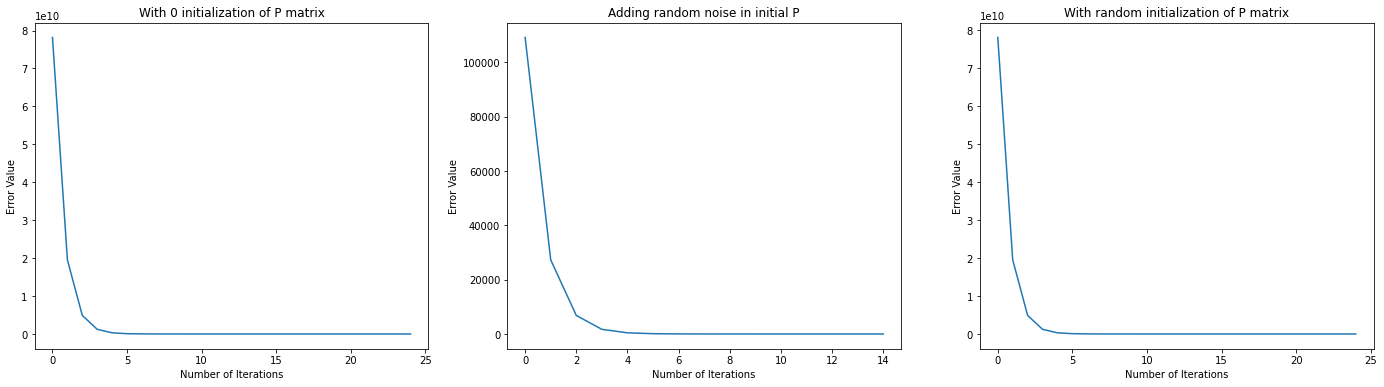

In [11]:
ROWS, COLS = 1, 3
H, W = 6, 8

fig, ax = plt.subplots(ROWS, COLS, figsize = (COLS*W, ROWS*H))

for i in range(COLS):
    ax[i].set_xlabel("Number of Iterations")
    ax[i].set_ylabel("Error Value")
    ax[i].set_title(st[i])
    ax[i].plot(errs[i])

We try out three different initialisations:
1. Zero initialised projection matrix
2. Random initialised projection matrix
3. Projection matrix initialised close to the ground truth by adding random noise  

While we are able to achieve convergence in all three cases, the number of iterations required was 34% fewer when the initialisation was close to the ground truth. This reflects the susceptibility of the problem to the quality of initialisation and highlights the importance of a good initial estimate - which can be obtained in practice from knowlege of the approximate position of the camera, etc.

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - **Ans-1 - Basics:** In a practical setting, Bundle Adjustment lies at the *backend* of the structure from motion pipeline. The *frontend*, which is responsible for collecting this data, works as follows: A series of images are taken of the same object, using (usually) the same camera, from different unknown locations. Then, on the first two consecutive images, we use SIFT or ORB to get feature points common to both of them. The 8 point algorithm then helps us estimate the Essential and the Fundamental matrices (up to scale) which are further decomposed into R and T (the rotation and translation between the two images). Once this is known, we triangulate back the points from those two images into the 3D world (using the same scale throughout). **Note that while doing this, it is known which image the points being backprojected came from, which is exactly the information stored in `camera_ind`**. Now, PnP can be used on correspondences between the reconstructed world and the third image to get the R, t of the third image (in the same scale), and we can repeat this process over all the other images. **Thus, we know which of the `points_2d` belong to which camera because those points are chosen after running SIFT/ORB or other feature detection algorithms on the image from that camera.**  


2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - **Ans-2 - Basics:** As explained in the frontend pipeline in the previous answer, the initial estimate of the 3D points is generated by triangulating and backprojecting the 2D points from the images, once the $F$, $E$, $R$ and $\mathbf{t}$ have been estimated (initially). Hence, because of how they are generated, it can be easily tracked which 3D point was generated by (and hence corresponds to) which 2D point. This can be done by assigning an index to each 2D point and labelling each 3D point with the same index.


3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - **Ans-3 - Transformations:** The project function uses the estimated camera intrinsics and extrinsics to project the estimates of the 3D points onto the 2D image planes. Each camera is at a different position/orientation, and hence it is necessary to transform the 3D point (which is in an arbitrary world frame) into the camera's local frame (the camera extrinsics). The way to do this is to first correct for rotation, by rotating the point from the world to the local camera frame, and then **correct for origin offset within this local camera frame**, i.e.:
    $$
    \mathbf{{}^{c}p} = R^{c}_{w}\mathbf{{}^{w}p} + \mathbf{{}^{c}t^{c}_{w}}
    $$
    _(The left superscript indicates which frame that representation of the vector lies in.)_  
    Thus, because the **translation vector, $\mathbf{{}^{c}t^{c}_{w}}$ lies in the camera frame**, it is necessary that the point $\mathbf{{}^{w}p}$ be **first rotated into the camera frame before it can be added to $\mathbf{{}^{c}t^{c}_{w}}$,** as coordinate representations of **vectors in different frames cannot directly be added.** Hence, we **cannot apply the rotation after the translation.**  
    However, if the translation was defined in the world frame itself, $\mathbf{{}^{w}t^{c}_{w}}$, then the transformation equation becomes:
    $$
    \mathbf{{}^{c}p} = R^{c}_{w}\left(\mathbf{{}^{w}p} + \mathbf{{}^{w}t^{c}_{w}}\right) = R^{c}_{w}\mathbf{{}^{w}p} + R^{c}_{w}\mathbf{{}^{w}t^{c}_{w}}
    $$
    This is however difficult to optimise as it couples together $R$ and $\mathbf{t}$, unless we treat the product as a separate parameter, which brings us back to the previous formulation (since $R^{c}_{w}\mathbf{{}^{w}t^{c}_{w}}$ is simply $\mathbf{{}^{c}t^{c}_{w}}$).


4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - **Ans-4 - Jacobian:** Because each row of the Jacobian corresponds to a residual, we have as many rows as the number of residuals, which is equal to the total number of 2D points we have (as our loss function measures the difference between the reprojected 2D points (calculated from the estimated 3D points and the estimated camera parameters) and the observed 2D points (from the images)). Because each 2D point contributes not one but two coordinates, a $x$ and and a $y$, we have twice as many residuals (and hence, as many rows in the Jacobian) as the number of 2D points.  
    In  class, we assumed that each of the $N$ points is visible in all $M$ images, hence giving us $MN$ 2D points, and hence $2MN$ residuals/rows in the Jacobian. Here, however, we have `camera_indices.size` 2D points (because each element in `camera_indices` maps a 2D point to an image), and hence twice as many residuals/rows in the Jacobian.


5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes.
    
        - **Ans 5.1 - Jacobian & Parameters:** During bundle adjustment, we optimise for the camera parameters and estimated 3D world point positions. Hence, there are *Number of camera parameters* $\times$ *Number of cameras* $+$ *Number of coordinates* $\times$ *Number of world points* parameters that we optimise over. In class, the camera projection matrix was represented as a $3 \times 4$ matrix, $P = K \left[R | t \right]$, giving us 12 parameters per camera. This is because we used $3 \times 3$ rotation matrices to represent rotations and another $3 \times 3$ matrix to represent the camera intrinsics. Here, however, we only have $9$ camera parameters, namely, $3$ to represent the axis-angle rotation, $3$ to represent the translation, the focal length and $2$ distortion parameters. Thus, the switch from rotation matrices to axis-angles and from the camera intrinsic matrix to individual intrinsic properties changed the number of parameters from $12$ to $9$ per camera.
<br/><br/>
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        
        - **Ans 5.2 - Jacobian & Parameters:** The bundle adjustment problem deals with optimising the estimates of camera positions and 3D world points generated by a Structure from Motion frontend. The camera intrinsics are known. Hence, by definition of the problem itself, the parameters being optimised are the 6 degrees of freedom per camera (3 rotatations and 3 translations) and the 3 degrees of freedom per world point ($x$, $y$ and $z$) giving a total of $6 \times$ `n_cameras` + $3 \times$ `n_points` parameters to be estimated.  
        However, this requires that the optimisation be performed over the $SO(3)$ manifold instead of Euclidean space. To avoid this, in class, we optimised the $3 \times 4$ projection matrix as it is, essentially optimising for all the intrinsic and extrinsic parameters ($P = K \left[R|t \right]$). Thus, the number of unknown parameters was $12 \times$ `n_cameras` + $3 \times$ `n_points`.  
        Here, however, we optimise over the intrinsic and extrinsic parameters separately - and represent the rotations using axis-angles to allow us to do so. Thus, we have $3$ rotation (axis-angle) parameters, $3$ translation paramters, and $3$ intrinsic camera parameters (this is the case here, we may have upto $5$ intrinsic parameters to worry about), giving us $9$ parameters per camera, for a total of $9 \times$ `n_cameras` + $3 \times$ `n_points` parameters.

        
6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - **Ans 6 - Sparsity, Residual Vector & Jacobian:**<br/> **(Structure of the Jacobian)** Every row in the Jacobian corresponds to one of the residuals, while every column corresponds to one of the parameters being optimised. As explained in the previous answers, we have $9 \times$ *Number of Cameras* + $3 \times$ *Number of world point* parameters, and hence, those many columns. Each observed 2D point provides $2$ equations (one for its $x$ and one for its $y$ coordinate) and hence, there are twice as many residuals (and hence, rows in the Jacobian) as the number of observations. In class, each of the $N$ world points were assumed to be visible in all $M$ images, giving us $2MN$ rows, while here, we have `camera_ind.size` observations, and twice as many rows. Another difference is that the residuals in class were ordered first according to the points, and then according to the images - while here they appear in no particular order, which is alright for as long as one order is consistently maintained.  
    __(Function of the code snippet)__ The code snippet marks the elements of this large Jacobian matrix which are not always $0$, allowing the `SciPy` solver to take advantage of the sparsity of the Jacobian. Using `NumPy`'s integer array indexing, for the two rows of every observation, all the $9$ columns corresponding to the parameters of the corresponding camera are set to $1$. Similarly, the next `for` loop sets all the $3$ columns corresponding to the world point involved in the $i^{th}$ observation to $1$, for both the rows of the observation ($x$ and $y$), for all $i$. Other elements are always $0$ (because they represent cameras and world points not involved in that observation), and contribute to the sparse structure of the Jacobian.

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**

1. First, we do feature matching using the following function calls:
   ```python
   sift = cv2.SIFT_create() # optional parameter nfeatures (number of features required)
   key1, desc1 = sift.detectAndCompute(img1, None) # None refers to the absence of additional parameters
   key2, desc2 = sift.detectAndCompute(img2, None)
   ```
   This returns the keypoints and their corresponding descriptions for the two images. Here, instead of SIFT, we could've also used SURF or ORB features. Now, we match the corresponding features between the two images, using a K-Nearest-Neighbour based matching.
   ```python
   matcher = cv2.FlannBasedMatcher({'algorithm'=0, 'trees'=5}, {'checks'=32})
   # initialisation of the kNN-based
   # matcher with recommended parameters
   matches = matcher.knnMatch(desc1, desc2, k=2) # match the descriptors
   ```
   After this, the matching points from within `matches` are separated into points in the first image (`pts1`) and points in the second image (`pts2`) as follows:
   ```python
   pts1 = np.array([key1[m[0].queryIdx].pt for m in matches])
   pts2 = np.array([key2[m[0].trainIdx].pt for m in matches])
   ```
   The Lowe test (discard a match if the first and second best matches are within 25% of each other) may be used here to improve the quality of matches.  
<br/>
2. Now that we have the corresponding points, we find the essential matrix using `cv2.findEssentialMatrix`. The parameters provided are the lists of matching points, `pts1` and `pts2` as well as the camera intrinsics, `K`. The `method` can be set to `cv2.RANSAC`, and RANSAC's threshold and probability values can be set.  
<br/>
3. Now that we have essential matrix, we can decompose it into R,t as following:

    `Rt = cv2.recoverPose(E, pts1, pts2, K)`: This takes Essential matrix, K matrix and the corresponding points in 2 images as input arguments and gives us R,t. `Rt[1]` would give us R and `Rt[2]` would give us t.  
<br/>
4. Now that we have the camera extrinsics (R and t), we find 3D points as follows:  
   (This calculates the points in the first camera's frame)
   ```python
   P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1)))) # [I | 0] is the first camera's extrinsic matrix
   P2 = K @ np.hstack((R, t)) # [R | t] is the second camera's extrinsic matrix
   ptsW = cv2.triangulatePoints(P1, P2, pts1, pts2) # triangulate back the points
   ptsW /= ptsW[3] # make homogenous
   ptsW[:3] # holds the world points
   ```